In [14]:
import os
import sys
from OCC.Core.STEPControl import STEPControl_Reader
from OCC.Core.TopoDS import TopoDS_Shape
from OCC.Core.TopAbs import TopAbs_EDGE, TopAbs_VERTEX, TopAbs_FACE
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.BRepGProp import brepgprop_VolumeProperties
from OCC.Core.GProp import GProp_GProps
from OCC.Core.GeomAbs import GeomAbs_Cylinder
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface
from OCC.Core.BRepLProp import BRepLProp_SLProps


from OCC.Core.BRep import BRep_Tool
from OCC.Core.GeomAbs import GeomAbs_CurveType
from OCC.Core.BRepTools import breptools_UVBounds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [15]:
#counting vertices, edages, faces
def analyze_step_file(file_path: str):
    # Load the STEP file
    step_reader = STEPControl_Reader()
    status = step_reader.ReadFile(file_path)
    if status != 1:  # If file load unsuccessful
        print(f"Error reading the STEP file: {file_path}")
        return None

    step_reader.TransferRoot()
    shape = step_reader.OneShape()

    # Initialize sets to hold unique vertices, edges, and faces
    vertices = set()
    edges = set()
    faces = set()

    # Explore edges
    explorer = TopExp_Explorer(shape, TopAbs_EDGE)
    while explorer.More():
        edges.add(explorer.Current())
        explorer.Next()

    # Explore vertices
    explorer.Init(shape, TopAbs_VERTEX)
    while explorer.More():
        vertices.add(explorer.Current())
        explorer.Next()

    # Explore faces
    explorer.Init(shape, TopAbs_FACE)
    while explorer.More():
        faces.add(explorer.Current())
        explorer.Next()

    # Return counts
    return len(vertices), len(edges), len(faces)

In [16]:
# Function to extract volume from a STEP file
def get_volume(file_path):
    step_reader = STEPControl_Reader()
    step_reader.ReadFile(file_path)
    step_reader.TransferRoots()
    shape = step_reader.Shape()
    
    props = GProp_GProps()
    brepgprop_VolumeProperties(shape, props)
    return props.Mass()

In [17]:

def curvature_analysis(step_file_path):
    # Read the STEP file
    step_reader = STEPControl_Reader()
    step_reader.ReadFile(step_file_path)
    step_reader.TransferRoots()
    shape = step_reader.Shape()

    # Go through each face in the shape
    explorer = TopExp_Explorer(shape, TopAbs_FACE)
    mean_curvatures = []
    gaussian_curvatures = []
    
    while explorer.More():
        face = explorer.Current()
        surface = BRepAdaptor_Surface(face)
        u_min, u_max, v_min, v_max = breptools_UVBounds(face)

        # Compute curvature at the midpoint (u, v)
        u_mid, v_mid = (u_min + u_max) / 2, (v_min + v_max) / 2
        props = BRepLProp_SLProps(surface, u_mid, v_mid, 2, 1e-6)
        if props.IsCurvatureDefined():
            mean_curvature = props.MeanCurvature()
            gaussian_curvature = props.GaussianCurvature()
            mean_curvatures.append(mean_curvature)
            gaussian_curvatures.append(gaussian_curvature)
        
        explorer.Next()

    return mean_curvatures, gaussian_curvatures


In [18]:
def detect_holes(step_file_path):
    # Read the STEP file
    step_reader = STEPControl_Reader()
    status = step_reader.ReadFile(step_file_path)
    if status != 1:  # Check if file reading was successful
        print(f"Error reading file: {step_file_path}")
        return None

    step_reader.TransferRoots()
    shape = step_reader.Shape()

    # Initialize explorer to iterate over faces
    explorer = TopExp_Explorer(shape, TopAbs_FACE)
    hole_count = 0
    hole_faces = []

    # Iterate over each face to detect cylindrical surfaces (holes)
    while explorer.More():
        face = explorer.Current()
        surface = BRepAdaptor_Surface(face)

        # Check if the surface is cylindrical, which often indicates a hole
        if surface.GetType() == GeomAbs_Cylinder:
            hole_count += 1
            hole_faces.append(face)  # Optionally, store the face representing the hole

        explorer.Next()

    return hole_count

In [19]:
# Define folder path containing STEP files
folder_path = "All"

# List all STEP files in the folder
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".step")]

In [20]:
results = []

# Process each STEP file and collect the results
for filename in os.listdir(folder_path):
    if filename.endswith('.step'):
        file_path = os.path.join(folder_path, filename)
        counts = analyze_step_file(file_path)
        if counts:
            vertices_count, edges_count, faces_count = counts
            # Append each result as a dictionary to the list
            results.append({
                'File': filename,
                'Vertices': vertices_count,
                'Edges': edges_count,
                'Faces': faces_count
            })

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# Display the DataFrame
print(df_results)


            File  Vertices  Edges  Faces
0  00000108.step        38     58     14
1  00000013.step       288    462     99
2  00000109.step       154    264     59
3  00000044.step        12     16      4
4  00000130.step       104    176     35


In [21]:
# Process each STEP file and get volumes
volumes = [get_volume(fp) for fp in file_paths]
df_results['Volume'] = volumes

/tmp/ipykernel_4989/3350199009.py:9: DeprecationWarning: Call to deprecated function brepgprop_VolumeProperties since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method brepgprop.VolumeProperties
  brepgprop_VolumeProperties(shape, props)
/tmp/ipykernel_4989/3350199009.py:9: DeprecationWarning: Call to deprecated function brepgprop_VolumeProperties since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method brepgprop.VolumeProperties
  brepgprop_VolumeProperties(shape, props)
/tmp/ipykernel_4989/3350199009.py:9: DeprecationWarning: Call to deprecated function brepgprop_VolumeProperties since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method brepgprop.VolumeProperties
  brepgprop_VolumeProperties(shape, props)
/tmp/ipykernel_4989/3350199009.py:9: DeprecationWarning: Call to deprecated function brepgprop_VolumeProperti

In [22]:
count_hole = [detect_holes(fp) for fp in file_paths]
df_results['count_hole'] = count_hole

In [23]:
print(df_results)

            File  Vertices  Edges  Faces        Volume  count_hole
0  00000108.step        38     58     14     24.978325           3
1  00000013.step       288    462     99  13131.287497          41
2  00000109.step       154    264     59   2633.459750          20
3  00000044.step        12     16      4   5958.849912           0
4  00000130.step       104    176     35  29443.836221          14


/tmp/ipykernel_4989/3239785730.py:16: DeprecationWarning: Call to deprecated function breptools_UVBounds since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method breptools.UVBounds
  u_min, u_max, v_min, v_max = breptools_UVBounds(face)
/tmp/ipykernel_4989/3239785730.py:16: DeprecationWarning: Call to deprecated function breptools_UVBounds since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method breptools.UVBounds
  u_min, u_max, v_min, v_max = breptools_UVBounds(face)
/tmp/ipykernel_4989/3239785730.py:16: DeprecationWarning: Call to deprecated function breptools_UVBounds since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method breptools.UVBounds
  u_min, u_max, v_min, v_max = breptools_UVBounds(face)
/tmp/ipykernel_4989/3239785730.py:16: DeprecationWarning: Call to deprecated function breptools_UVBounds since pyth

([-0.08748906386701662, -0.4459106376454567, -0.15748031496062992, -0.29028383217149106, -0.08748906386701662, -0.08748906386701662, -0.29028383218302484, -0.29028383217158055, -0.3524160120825788, -0.3524168491200754, -0.2902838321833551, -0.3524168491200754, -0.3524160120825788, -0.08748906386701662, 0.0, -0.15748031496062992, 0.0, 0.0, 0.0, -0.08202099737532807, 0.0, -0.05179320865664362, -0.0699912510936133, 0.0, 0.0], [0.0, 0.0822202366045384, -0.0, -0.16286134681905615, -0.0, -0.0, -0.16286134680085906, -0.16286134681891523, -0.06501539420317114, -0.06501407603382373, -0.16286134680034456, -0.06501407603382373, -0.06501539420317114, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0])


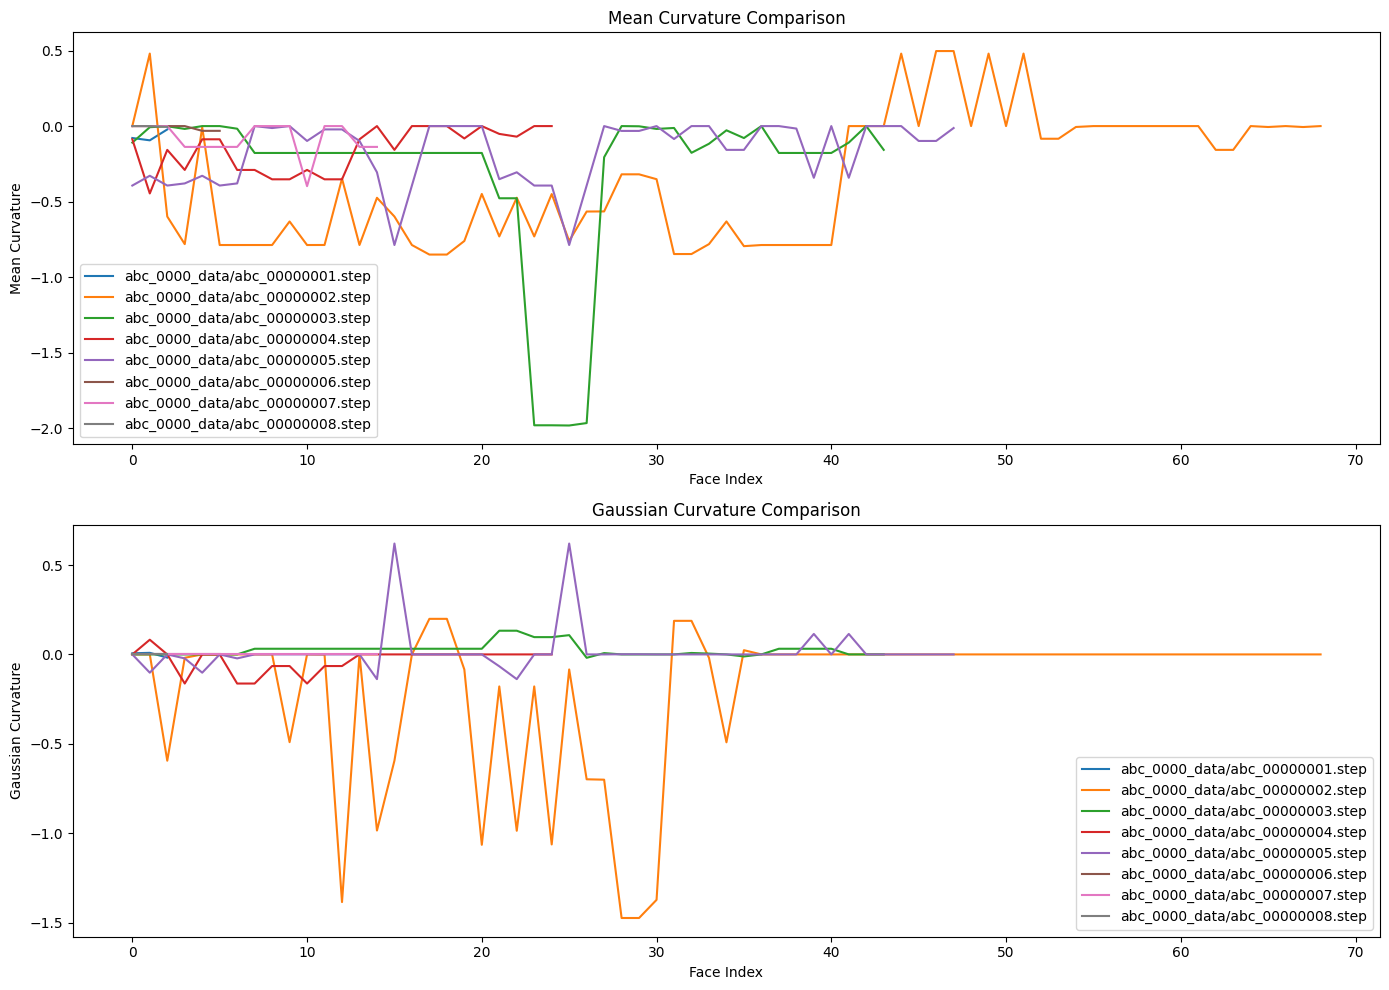

In [24]:
file_paths = ['abc_0000_data/abc_00000001.step', 'abc_0000_data/abc_00000002.step', 'abc_0000_data/abc_00000003.step', 'abc_0000_data/abc_00000004.step','abc_0000_data/abc_00000005.step', 'abc_0000_data/abc_00000006.step', 'abc_0000_data/abc_00000007.step', 'abc_0000_data/abc_00000008.step']  # replace with your file paths
curvature_data = {}

# Process each file and store its curvature data
for file_path in file_paths:
    mean_curvatures, gaussian_curvatures = curvature_analysis(file_path)
    curvature_data[file_path] = (mean_curvatures, gaussian_curvatures)

print(curvature_data['abc_0000_data/abc_00000004.step'])

# Visualize the curvature comparison
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot Mean Curvature for each file
for file_path, (mean_curvatures, _) in curvature_data.items():
    ax[0].plot(range(len(mean_curvatures)), mean_curvatures, label=file_path)
ax[0].set_title("Mean Curvature Comparison")
ax[0].set_xlabel("Face Index")
ax[0].set_ylabel("Mean Curvature")
ax[0].legend()

# Plot Gaussian Curvature for each file
for file_path, (_, gaussian_curvatures) in curvature_data.items():
    ax[1].plot(range(len(gaussian_curvatures)), gaussian_curvatures, label=file_path)
ax[1].set_title("Gaussian Curvature Comparison")
ax[1].set_xlabel("Face Index")
ax[1].set_ylabel("Gaussian Curvature")
ax[1].legend()

plt.tight_layout()
plt.show()